In [ ]:
 import kagglehub

# Download latest version
path = kagglehub.dataset_download("rm1000/brain-tumor-mri-scans")

print("Path to dataset files:", path)

100%|██████████| 236M/236M [00:01<00:00, 170MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1


In [ ]:
import os                                                               # Used to navigate through folders where the dataset is stored
import numpy as np                                                      # Used to read images from disk.
import cv2                                                              # Stores images as numerical arrays for processing
import matplotlib.pyplot as plt                                         # Used to display images from the dataset.
from sklearn.model_selection import train_test_split                    # Used to split dataset into training and testing sets.
from keras.utils import to_categorical                                  # Converts integer class labels into one-hot encoded vectors.
from keras.models import Sequential                                     # Used to build the neural network model.
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # These layers are the building blocks of your CNN model


In [ ]:
# Set dataset path
dataset_path = "/root/.cache/kagglehub/datasets/rm1000/brain-tumor-mri-scans/versions/1"

# Define classes
classes = ["glioma", "healthy", "meningioma", "pituitary"]

In [ ]:
# Preprocess image: grayscale, resize, normalize, add channel dimension
def preprocess_image(img_path, image_size=(128, 128)):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Reads the image from the file path in grayscale mode.

     # Handling Error
    if img is None:
        print(f"Warning: Unable to read image {img_path}")    # Debugging message
        return None
    img = cv2.resize(img, image_size)   # Resize image
    img = img / 255.0                   # Normalize pixel values (0-1)
    img = np.expand_dims(img, axis=-1)  # Adds a channel dimension at the end. (128, 128, 1)
    return img


In [ ]:
def load_preprocessed_data(dataset_path, classes):
    images = []                                                # stores processed images
    labels = []                                                # stores corresponding class labels
    class_dict = {name: idx for idx, name in enumerate(classes)}   # Class mapping

    # Loop Through Each Class Folder
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue
        # Loop for images
        for img_name in os.listdir(class_path):              # lists all image filenames in the class folder.
            img_path = os.path.join(class_path, img_name)

            img = preprocess_image(img_path)                 # Function calling (preprocess_image)

            # checks if the image is valid
            if img is not None:
                images.append(img)
                labels.append(class_dict[class_name])

    # Converts list to numpy array
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_dict

# Load data
images, labels, class_dict = load_preprocessed_data(dataset_path, classes)       # Using the Function
print(f"Loaded {len(images)} images with shape: {images[0].shape} and {len(set(labels))} classes")


Loaded 7023 images with shape: (128, 128, 1) and 4 classes


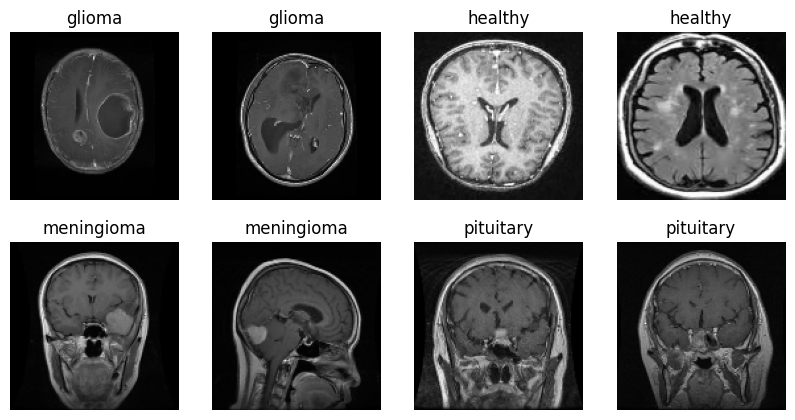

In [ ]:
# Fuction for visualizing the images
def visualize_images(images, labels, class_dict, num_images=8):
    plt.figure(figsize=(10, 5))                   # Create a Figure for Displaying Images
    unique_classes = list(class_dict.values())    # Used Extracts the numeric class labels from the class dictionary.
    samples_per_class = num_images // len(unique_classes)   # Calculates how many images to show per class.

    idx = 0                         # A counter to track the position in the subplot grid.

    #Loops through each class's numeric value, e.g., 0, 1, 2, 3.
    for class_val in unique_classes:
        class_indices = np.where(labels == class_val)[0][:samples_per_class]
        # Loop Over Each Selected Image
        for i in class_indices:
            plt.subplot(2, 4, idx + 1)
            plt.imshow(images[i].squeeze(), cmap='gray')    # Displays the image
            class_name = list(class_dict.keys())[list(class_dict.values()).index(labels[i])]
            plt.title(class_name)
            plt.axis('off')
            idx += 1
    plt.show()        # Show the Grid of Images

visualize_images(images, labels, class_dict)    # calling the fuction


In [ ]:
# Splitting the Dataset into Train/Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

y_train_cat = to_categorical(y_train, num_classes=len(classes))   # converts integer labels to one-hot encoded format.
y_test_cat = to_categorical(y_test, num_classes=len(classes))

print("Training data shape:", X_train.shape)    # Prints the shape (dimensions) of the training and testing data.
print("Test data shape:", X_test.shape)


Training data shape: (5618, 128, 128, 1)
Test data shape: (1405, 128, 128, 1)


In [ ]:
# Model Definition
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),   # Applies 32 convolution filters of size 3x3.
    MaxPooling2D((2, 2)),                                               # Introduces non-linearity using ReLU.

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),                                # Downsamples the feature map by selecting the maximum value in each 2x2 window.

    Flatten(),                # Flattens the 2D feature maps into a 1D vector.
    Dense(128, activation='relu'),    # Fully connected layer with 128 neurons.
    Dropout(0.3),       # Prevents overfitting by forcing the network to learn more robust features.
    Dense(len(classes), activation='softmax')
])

# Model Compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])   # Optimizer decide how the model will learn
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,260 (28.20 MB)

 Trainable params: 7,392,260 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model Training
history = model.fit(
    X_train, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 113s 791ms/step - accuracy: 0.5835 - loss: 1.0080 - val_accuracy: 0.8274 - val_loss: 0.4615
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 145s 812ms/step - accuracy: 0.8497 - loss: 0.4007 - val_accuracy: 0.8310 - val_loss: 0.4290
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 142s 814ms/step - accuracy: 0.8912 - loss: 0.3011 - val_accuracy: 0.8639 - val_loss: 0.3728
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 138s 783ms/step - accuracy: 0.9336 - loss: 0.1861 - val_accuracy: 0.9048 - val_loss: 0.2837
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 141s 774ms/step - accuracy: 0.9647 - loss: 0.1088 - val_accuracy: 0.9324 - val_loss: 0.2084
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 107s 757ms/step - accuracy: 0.9698 - loss: 0.0823 - val_accuracy: 0.9288 - val_loss: 0.2321
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 140s 742ms/step - accuracy: 0.9840 - loss: 0.0504 - val_accuracy: 0.9404 - val_loss: 0.2104
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 108s 764ms/step - accuracy: 0.9818 -

In [ ]:
import tensorflow as tf                                             # 	Main deep learning backend
from tensorflow.keras.models import Sequential                      # Builds models layer-by-layer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization   # Layers for CNN
from tensorflow.keras.utils import to_categorical             # Converts labels to one-hot encoding
from sklearn.model_selection import train_test_split          # Splits data into train/test sets
import matplotlib.pyplot as plt                               # Visualizes data/graphs
import numpy as np                                            # Numerical operations on arrays
from tensorflow.keras import layers, models


In [ ]:
def preprocess_image_rgb(img_path):
    img = cv2.imread(img_path)  # Load as RGB by default
    img = cv2.resize(img, (128, 128))
    img = img / 255.0             # Normalization
    return img


In [ ]:
def load_preprocessed_data_rgb(dataset_path, classes):
    images = []
    labels = []
    class_dict = {name: idx for idx, name in enumerate(classes)}

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = preprocess_image_rgb(img_path)
            if img is not None:
                images.append(img)
                labels.append(class_dict[class_name])

    images = np.array(images)
    labels = np.array(labels)
    return images, labels


In [ ]:
images_rgb, labels_rgb = load_preprocessed_data_rgb(dataset_path, classes)

# Split data
X_train_rgb, X_test_rgb, y_train_rgb, y_test_rgb = train_test_split(
    images_rgb, labels_rgb, test_size=0.2, random_state=42, stratify=labels_rgb
)

# One-hot encode
y_train_rgb_cat = to_categorical(y_train_rgb, num_classes=len(classes))
y_test_rgb_cat = to_categorical(y_test_rgb, num_classes=len(classes))


In [ ]:
def build_alexnet(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=2),

        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((3, 3), strides=2),

        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=2),

        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Compile and train
alexnet_model = build_alexnet((128, 128, 3), len(classes))
alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

alexnet_history = alexnet_model.fit(
    X_train_rgb, y_train_rgb_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.5400 - loss: 2.1896 - val_accuracy: 0.5151 - val_loss: 1.2705
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 324s 2s/step - accuracy: 0.7047 - loss: 0.7753 - val_accuracy: 0.6210 - val_loss: 0.9097
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.7827 - loss: 0.5797 - val_accuracy: 0.6975 - val_loss: 0.9212
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.8039 - loss: 0.5119 - val_accuracy: 0.7313 - val_loss: 0.6976
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.8474 - loss: 0.4163 - val_accuracy: 0.7464 - val_loss: 0.5933
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.8916 - loss: 0.3237 - val_accuracy: 0.8746 - val_loss: 0.3523
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.8846 - loss: 0.3454 - val_accuracy: 0.8514 - val_loss: 0.4361
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.8980 - loss: 0.2779 - val_accu

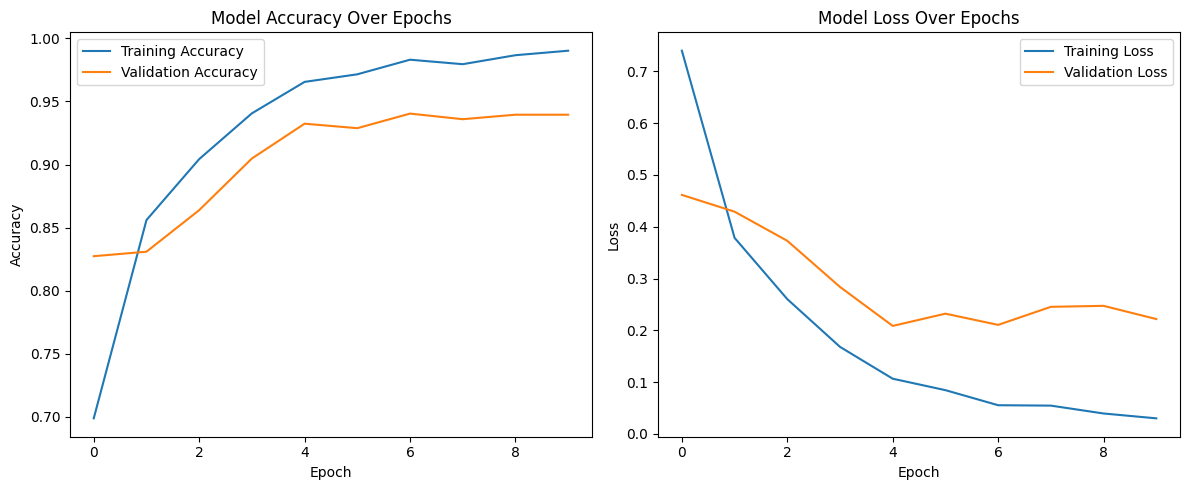

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
